<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/ssrVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised VAE for data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large unlabelled data set with a much stronger orientational disorder.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installations
!pip install -q pyroved kornia

In [ ]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Helper function
def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE)
    card2 = cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE)
    card3 = cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE)
    card4 = cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE)
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.Resize((64, 64)),
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

We are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

In [ ]:
cards = get_data()

In [ ]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=4, translation=None, 
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

Here's the supervised part of our training set:

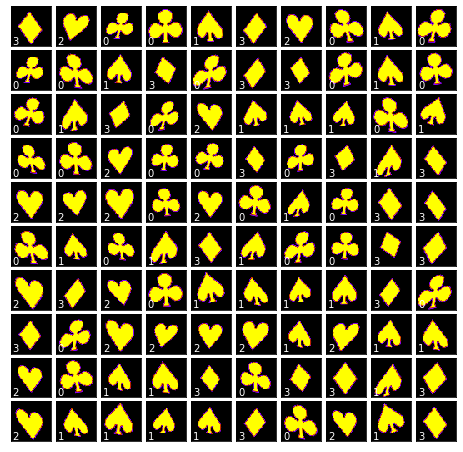

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

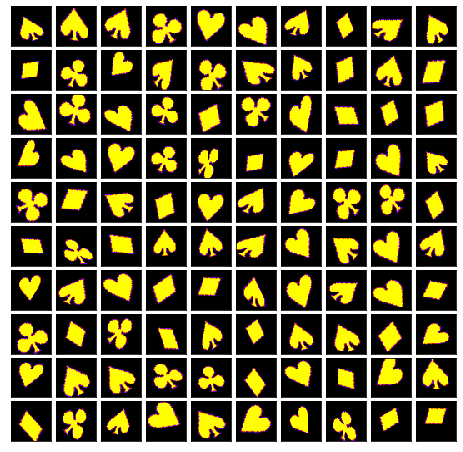

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [ ]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [ ]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-(tr)VAE model

Finally, we will train a semi supervised (ss) VAE model. The goal is to use a limited amount (~6%) of labeled data with small positional (orientation+translation) disorder to categorize large volumes of unlabeled data characterized by a (much) higher positional disorder. During the training, we are also going to enforce **t**ranslational and **r**otational invariance (hence, *ss-tr*VAE)

Epoch: 1 Training loss: 814.2280, Test accuracy: 0.2923
Epoch: 2 Training loss: 513.3541, Test accuracy: 0.4753
Epoch: 3 Training loss: 470.4111, Test accuracy: 0.4983
Epoch: 4 Training loss: 427.6521, Test accuracy: 0.5245
Epoch: 5 Training loss: 399.2229, Test accuracy: 0.6168
Epoch: 6 Training loss: 379.4226, Test accuracy: 0.6665
Epoch: 7 Training loss: 367.0941, Test accuracy: 0.6833
Epoch: 8 Training loss: 355.9975, Test accuracy: 0.6763
Epoch: 9 Training loss: 344.6696, Test accuracy: 0.6725
Epoch: 10 Training loss: 331.4763, Test accuracy: 0.6750


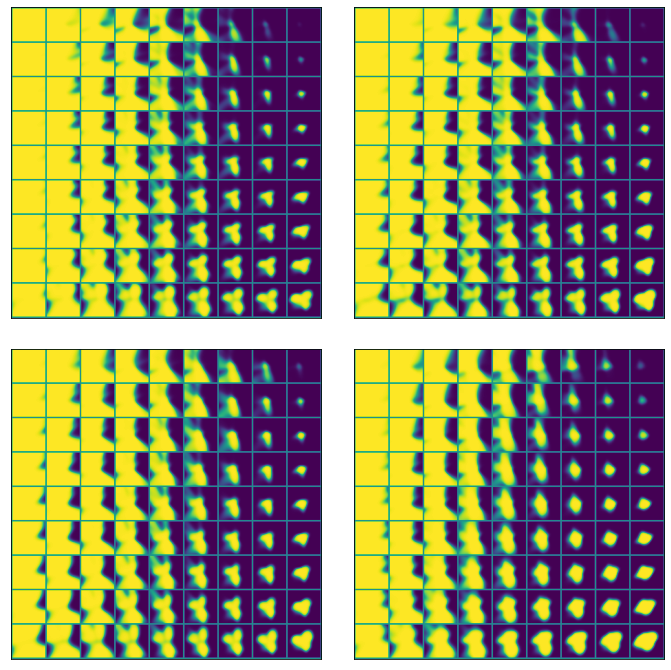

Epoch: 11 Training loss: 318.8646, Test accuracy: 0.6995
Epoch: 12 Training loss: 307.7892, Test accuracy: 0.7635
Epoch: 13 Training loss: 294.8849, Test accuracy: 0.8127
Epoch: 14 Training loss: 285.7578, Test accuracy: 0.8518
Epoch: 15 Training loss: 277.6327, Test accuracy: 0.8560
Epoch: 16 Training loss: 266.8055, Test accuracy: 0.8612
Epoch: 17 Training loss: 262.4717, Test accuracy: 0.8658
Epoch: 18 Training loss: 257.5368, Test accuracy: 0.8658
Epoch: 19 Training loss: 255.9102, Test accuracy: 0.8788
Epoch: 20 Training loss: 246.4550, Test accuracy: 0.8770


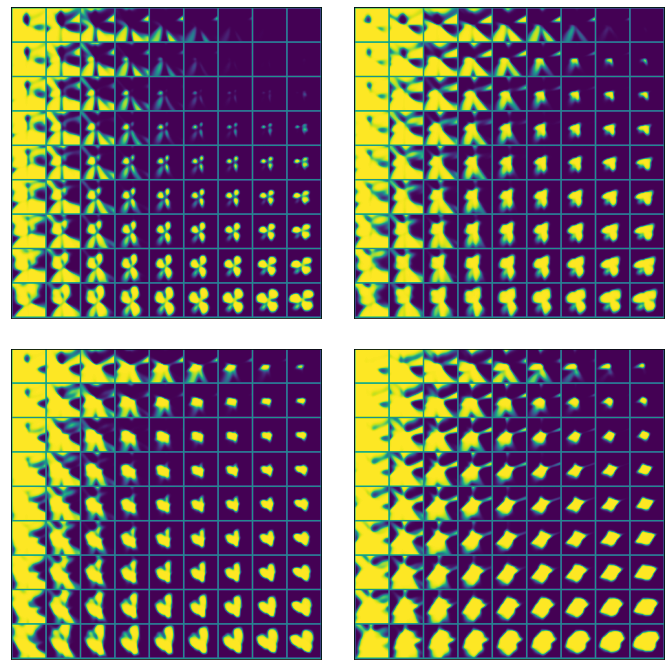

Epoch: 21 Training loss: 243.4096, Test accuracy: 0.8745
Epoch: 22 Training loss: 241.4255, Test accuracy: 0.8740
Epoch: 23 Training loss: 241.8152, Test accuracy: 0.8660
Epoch: 24 Training loss: 236.5429, Test accuracy: 0.8680
Epoch: 25 Training loss: 236.3412, Test accuracy: 0.8680
Epoch: 26 Training loss: 233.0397, Test accuracy: 0.8765
Epoch: 27 Training loss: 232.2412, Test accuracy: 0.8722
Epoch: 28 Training loss: 229.0113, Test accuracy: 0.8628
Epoch: 29 Training loss: 229.6967, Test accuracy: 0.8742
Epoch: 30 Training loss: 226.1491, Test accuracy: 0.8718


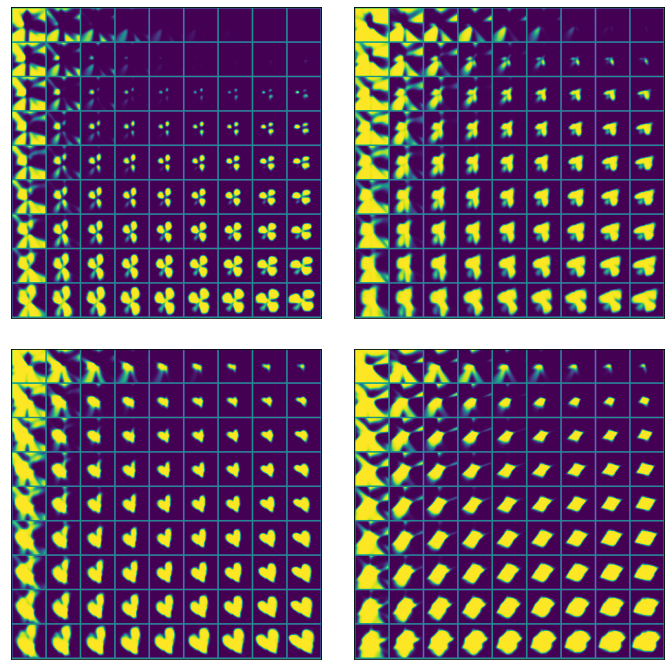

Epoch: 31 Training loss: 224.2497, Test accuracy: 0.8825
Epoch: 32 Training loss: 221.1947, Test accuracy: 0.8760
Epoch: 33 Training loss: 222.0464, Test accuracy: 0.8718
Epoch: 34 Training loss: 220.8515, Test accuracy: 0.8728
Epoch: 35 Training loss: 216.6197, Test accuracy: 0.8738
Epoch: 36 Training loss: 216.6704, Test accuracy: 0.8702
Epoch: 37 Training loss: 215.1408, Test accuracy: 0.8615
Epoch: 38 Training loss: 215.1434, Test accuracy: 0.8760
Epoch: 39 Training loss: 214.0366, Test accuracy: 0.8845
Epoch: 40 Training loss: 211.1255, Test accuracy: 0.8805


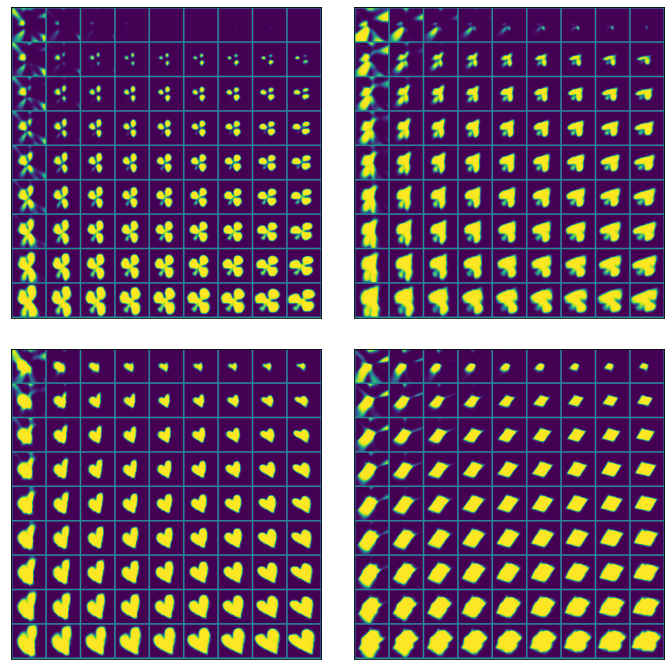

Epoch: 41 Training loss: 211.4783, Test accuracy: 0.8535
Epoch: 42 Training loss: 211.0391, Test accuracy: 0.8745
Epoch: 43 Training loss: 211.3540, Test accuracy: 0.8802
Epoch: 44 Training loss: 206.5647, Test accuracy: 0.8688
Epoch: 45 Training loss: 205.1888, Test accuracy: 0.8748
Epoch: 46 Training loss: 206.3394, Test accuracy: 0.8760
Epoch: 47 Training loss: 203.5759, Test accuracy: 0.8728
Epoch: 48 Training loss: 203.5864, Test accuracy: 0.8828
Epoch: 49 Training loss: 202.7586, Test accuracy: 0.8782
Epoch: 50 Training loss: 200.9268, Test accuracy: 0.8785


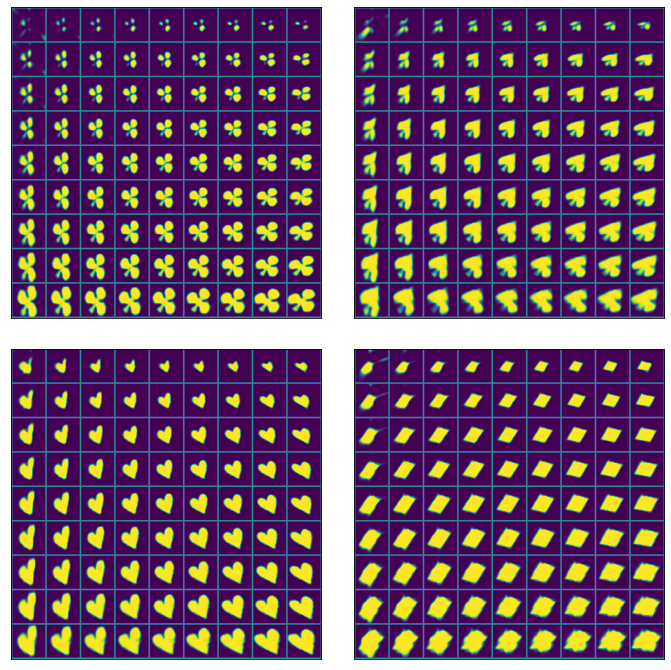

Epoch: 51 Training loss: 202.8111, Test accuracy: 0.8838
Epoch: 52 Training loss: 202.8150, Test accuracy: 0.8805
Epoch: 53 Training loss: 196.8768, Test accuracy: 0.8810
Epoch: 54 Training loss: 196.0631, Test accuracy: 0.8752
Epoch: 55 Training loss: 198.5447, Test accuracy: 0.8740
Epoch: 56 Training loss: 194.9602, Test accuracy: 0.8802
Epoch: 57 Training loss: 195.9149, Test accuracy: 0.8828
Epoch: 58 Training loss: 192.3182, Test accuracy: 0.8702
Epoch: 59 Training loss: 193.6489, Test accuracy: 0.8735
Epoch: 60 Training loss: 191.5100, Test accuracy: 0.8778


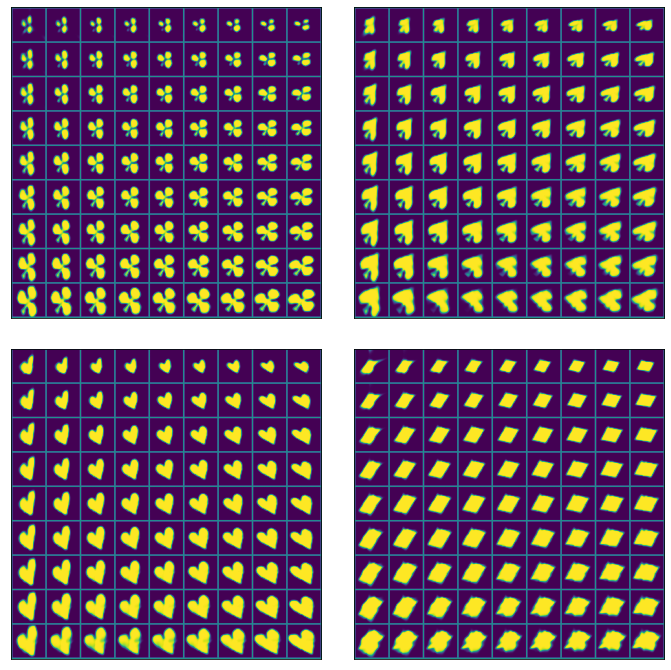

Epoch: 61 Training loss: 188.1171, Test accuracy: 0.8780
Epoch: 62 Training loss: 187.9669, Test accuracy: 0.8740
Epoch: 63 Training loss: 188.8077, Test accuracy: 0.8645
Epoch: 64 Training loss: 187.4628, Test accuracy: 0.8745
Epoch: 65 Training loss: 190.6318, Test accuracy: 0.8745
Epoch: 66 Training loss: 187.1048, Test accuracy: 0.8800
Epoch: 67 Training loss: 183.7552, Test accuracy: 0.8702
Epoch: 68 Training loss: 182.1317, Test accuracy: 0.8698
Epoch: 69 Training loss: 187.5779, Test accuracy: 0.8795
Epoch: 70 Training loss: 183.4480, Test accuracy: 0.8730


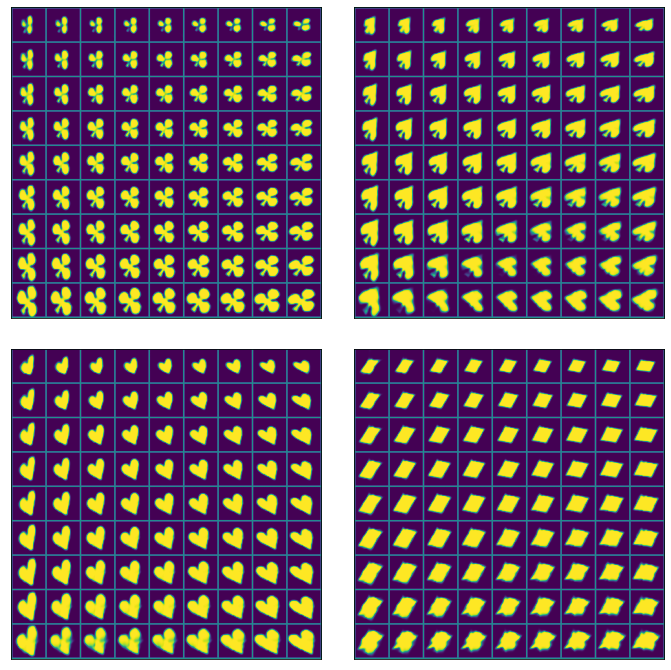

Epoch: 71 Training loss: 182.4146, Test accuracy: 0.8778
Epoch: 72 Training loss: 177.8369, Test accuracy: 0.8800
Epoch: 73 Training loss: 178.2618, Test accuracy: 0.8818
Epoch: 74 Training loss: 182.0164, Test accuracy: 0.8768
Epoch: 75 Training loss: 179.1087, Test accuracy: 0.8768
Epoch: 76 Training loss: 174.7737, Test accuracy: 0.8828
Epoch: 77 Training loss: 175.3572, Test accuracy: 0.8642
Epoch: 78 Training loss: 174.5838, Test accuracy: 0.8732
Epoch: 79 Training loss: 172.0572, Test accuracy: 0.8640
Epoch: 80 Training loss: 175.8238, Test accuracy: 0.8738


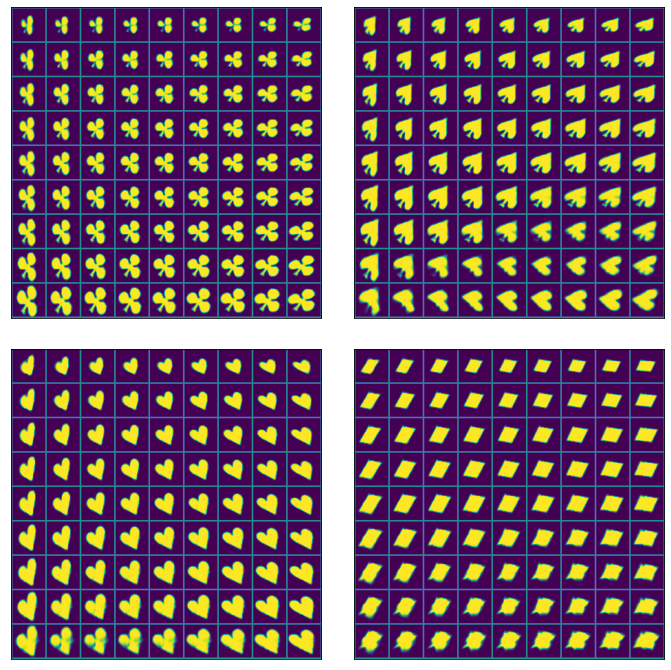

In [ ]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 
coord = 3  # add 3 "special" latent variables to enforce rotational and translational invariance

# Initialize model
ssvae = pv.models.sstrVAE(
    data_dim, latent_dim, num_classes, coord,
    dx_prior=.1)

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(80):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned altent manifolds every 10 epoch
    if (e+1) % 10 == 0:
        plot_manifolds(ssvae)

Looks like we achieved ~88% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, shear deformation and scale, which are encoded in the first (left to right) and second (top to bottom) latent variables. 